In [1]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
import glob
import networkx as nx
import Bio.KEGG.KGML.KGML_parser as keg

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

python 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
numpy 1.19.1
pandas 1.1.1
matplotlib 3.3.1


# KEGG net construction

In [2]:
# mapping human gene symbol to entrez
dat=pd.read_table('data_ori/Sym2Entrez.txt',sep='\t')
dat.columns=['sym','entrez']
dat=dat.loc[dat['entrez'].notnull()]
dat=dat.loc[dat['sym'].notnull()]
dat['entrez']=dat['entrez'].astype(int).astype(str)

e2s=dat.set_index('entrez')
e2s_dic=e2s['sym'].to_dict() # e2s_dic={'1': 'A1BG', '503538': 'A1BG-AS1': ,...}

def construct_kegg_net(kgml_list):
    keggNet=nx.DiGraph()
    for kgml in kgml_list:
        kegg_ob=keg.read(open(kgml,'r'))
        edge_list=get_edge_info_from_parsed_object(kegg_ob)
        for (n1,n2,prop) in edge_list:
            keggNet.add_edge(n1,n2,prop=prop)
            
    print("#### Net info")
    print("nodes: {}".format(len(keggNet.nodes())))
    print("edges: {}".format(len(keggNet.edges())))
    
    return keggNet


def get_edge_info_from_parsed_object(kegg_ob):
    edge_list=[]
    
    rel_cnt=0
    for rel in kegg_ob.relations:
        prop=get_rel_subtypes(rel)

        if prop=='NA':
            continue
            
        rel_cnt+=1
        for n1 in rel.entry1.name.split(' '):
            n1=n1.replace("hsa:","")
            if n1 not in e2s_dic.keys():
                continue
            n1=e2s_dic[n1]
            for n2 in rel.entry2.name.split(' '):
                n2=n2.replace("hsa:","")
                if n2 not in e2s_dic.keys():
                    continue
                n2=e2s_dic[n2]
                edge_list.append((n1,n2,prop))
     
    return edge_list

def get_rel_subtypes(rel):
    if len(rel.subtypes)==0:
        return 'NA'
    
    return '&'.join([i[0] for i in rel.subtypes])    

In [3]:
kgml_list=glob.glob('data_ori/KEGG/selected_pathway_all/hsa*.xml')
KEGG_all_net=construct_kegg_net(kgml_list)

#### Net info
nodes: 1678
edges: 12617


# functions for refining process based on KEGG

In [4]:
def get_sig_selected_SL(SL, fdr_th, sig_SL_cnt_th, KEGG_all_net):
    
    sig_SL=SL.loc[SL['fdr']<fdr_th].copy()
    print('# of the originally selected significant SLs: ', len(sig_SL))
    sig_SL_ori_cnt=sig_SL["mut_gene"].value_counts()
    
    sig_SL=sig_SL.loc[sig_SL['dep_gene'].isin(KEGG_all_net.nodes())]
    print('# of the SLs in the KEGG net among the selected significant SLs: ', len(sig_SL))
    sig_SL_cnt=sig_SL["mut_gene"].value_counts()
    
    sig_SL_cnt_merged=pd.concat([sig_SL_ori_cnt, sig_SL_cnt],axis=1)
    sig_SL_cnt_merged.loc['sum']=sig_SL_cnt_merged.sum(axis=0)
    sig_SL_cnt_merged.columns=['ori','init']
    sig_SL_cnt_merged.sort_values(by='init',inplace=True, ascending=False)
    
    freq_mut_gene=list(sig_SL_cnt.loc[sig_SL_cnt>=sig_SL_cnt_th].index)
    sig_selected_SL=sig_SL.loc[sig_SL['mut_gene'].isin(freq_mut_gene)]
    print('# of the SLs in the KEGG net equal or more than {} occurance: '.format(sig_SL_cnt_th), len(sig_selected_SL))
    sig_selected_SL_cnt=sig_selected_SL["mut_gene"].value_counts()

    return sig_SL_cnt_merged, sig_selected_SL, sig_selected_SL_cnt


In [5]:


def add_all_path_to_local_net(KEGG_all_net, gene, sg, KEGG_local_net, DST):
    for path in nx.all_simple_paths(KEGG_all_net, source=gene, target=sg, cutoff=DST):
        for nd1,nd2 in zip(path[:-1],path[1:]):
            KEGG_local_net.add_edge(nd1,nd2,prop=KEGG_all_net[nd1][nd2]['prop'])

def get_connected_dep_genes(KEGG_all_net, dep_genes, DST):
    KEGG_local_net=nx.DiGraph()
    
    corrected_dep_genes=[]
    for gene in dep_genes:
        gene_nbrs=list(nx.single_source_shortest_path_length(KEGG_all_net, gene, cutoff=DST))
        shared_genes=list(set(gene_nbrs)&set(dep_genes))
        shared_genes.remove(gene)
        
        if len(shared_genes)==0:
            continue
        
        corrected_dep_genes+=shared_genes+[gene]

        for sg in shared_genes:
            add_all_path_to_local_net(KEGG_all_net, gene, sg, KEGG_local_net, DST)
            
    return list(set(corrected_dep_genes)), KEGG_local_net

def attach_neg_fdr_to_nodes(KEGG_local_net, SL, mut_gene):
    SL_mut=SL.loc[SL['mut_gene']==mut_gene]
    
    for nd1 in KEGG_local_net.nodes():
        if nd1 in list(SL_mut['dep_gene']):
            fdr=SL_mut.loc[SL_mut['dep_gene']==nd1,'fdr'].iloc[0]
            t_val=SL_mut.loc[SL_mut['dep_gene']==nd1,'t_val'].iloc[0] 
            if t_val < 0:
                fdr=-fdr
                
        else:
            fdr=np.nan
        
        KEGG_local_net.nodes[nd1]['fdr']=fdr
    
def correct_sig_SL_with_KEGG(sig_selected_SL, sig_selected_SL_cnt, SL, tp, KEGG_all_net, DST, sub_net_vis=False, mut='ALL', ax=None):
    corrected_SL=sig_selected_SL.copy()
    for mut_gene in sig_selected_SL_cnt.index:
        dep_genes=sig_selected_SL.loc[sig_selected_SL['mut_gene']==mut_gene, 'dep_gene']
        corrected_dep_genes, KEGG_local_net=get_connected_dep_genes(KEGG_all_net, dep_genes, DST)
        
        if (len(corrected_dep_genes)!=0) and (sub_net_vis==True) and (mut_gene==mut):
            attach_neg_fdr_to_nodes(KEGG_local_net, SL, mut_gene)
            KEGG_local_net_visualization(KEGG_local_net, mut_gene,DST, tp, ax)
        
        drop_index=corrected_SL.loc[(corrected_SL['mut_gene']==mut_gene)&(~corrected_SL['dep_gene'].isin(corrected_dep_genes))].index
        corrected_SL=corrected_SL.drop(drop_index)
    
    corrected_SL_cnt=corrected_SL.groupby(["mut_gene"])["fdr"].size().sort_values(ascending=False)
    
    return corrected_SL, corrected_SL_cnt
    
    

# read SL files

In [6]:
crp_SL=pd.read_table('result_SL/CRISPER_M003_I10_WI_Exp_fdr.txt',sep='\t')
shr_SL=pd.read_table('result_SL/shRNA_M003_I10_WI_Exp_fdr.txt',sep='\t')

# apply refining process and write the results

In [7]:
fdr_th=0.2
sig_SL_cnt_th=2

def organizing_refinement_result(df):
    print(df.shape)
    df_gp=df.groupby(['mut_gene'])['dep_gene'].apply(list).to_frame()
    df_gp['len']=df_gp['dep_gene'].map(lambda x: len(x))
    return df_gp

def diff_set(row):
    init=row['INIT.']
    dst2=row['DST=2']
    dst1=row['DST=1']

    if dst2!=dst2:
        dst2=[]

    if dst1!=dst1:
        dst1=[]

    init=list(set(init)-set(dst2))
    dst2=list(set(dst2)-set(dst1))

    return pd.Series({'DST=1':dst1,'DST=2':dst2,'INIT.':init})

def refinement_process(SL,tp):
    sig_SL_cnt_merged, sig_selected_SL, sig_selected_SL_cnt=get_sig_selected_SL(SL, fdr_th, sig_SL_cnt_th, KEGG_all_net)
    init=organizing_refinement_result(sig_selected_SL)

    corrected_SL2, corrected_SL_cnt2=correct_sig_SL_with_KEGG(sig_selected_SL, sig_selected_SL_cnt, SL, tp, KEGG_all_net,
                                                              DST=2, sub_net_vis=False)
    dst2=organizing_refinement_result(corrected_SL2)
    
    corrected_SL1, corrected_SL_cnt1=correct_sig_SL_with_KEGG(sig_selected_SL, sig_selected_SL_cnt, SL, tp, KEGG_all_net,
                                                              DST=1, sub_net_vis=False)
    dst1=organizing_refinement_result(corrected_SL1)
    
    df_ct=pd.concat([init,dst2,dst1], axis=1)
    df_ct.columns=['INIT.','lenI','DST=2','len2','DST=1','len1']
    
    df_ct=df_ct.sort_values(by=['lenI','len2','len1'], ascending=False)
    df_diff=df_ct.apply(diff_set,axis=1)
    df_diff.to_csv('result_main/{}_diff_table_KEGG.txt'.format(tp),sep='\t')
    
    df_stat=pd.concat([sig_SL_cnt_merged, df_ct], axis=1)
    df_stat=df_stat.drop(columns=['INIT.','DST=2','DST=1'])
    df_stat.to_csv('result_main/{}_SL_stat_KEGG.txt'.format(tp),sep='\t', na_rep=0)
    
    return [sig_selected_SL_cnt, corrected_SL_cnt2, corrected_SL_cnt1]

crp_list=refinement_process(crp_SL,'crp')
shr_list=refinement_process(shr_SL,'shr')

# of the originally selected significant SLs:  1740
# of the SLs in the KEGG net among the selected significant SLs:  525
# of the SLs in the KEGG net equal or more than 2 occurance:  162
(162, 5)
(73, 5)
(65, 5)
# of the originally selected significant SLs:  1389
# of the SLs in the KEGG net among the selected significant SLs:  417
# of the SLs in the KEGG net equal or more than 2 occurance:  105
(105, 5)
(45, 5)
(23, 5)


# visualization refining results with bar graph

<AxesSubplot:xlabel='# of synthetic partners', ylabel='MUT.'>

<AxesSubplot:xlabel='# of synthetic partners', ylabel='MUT.'>

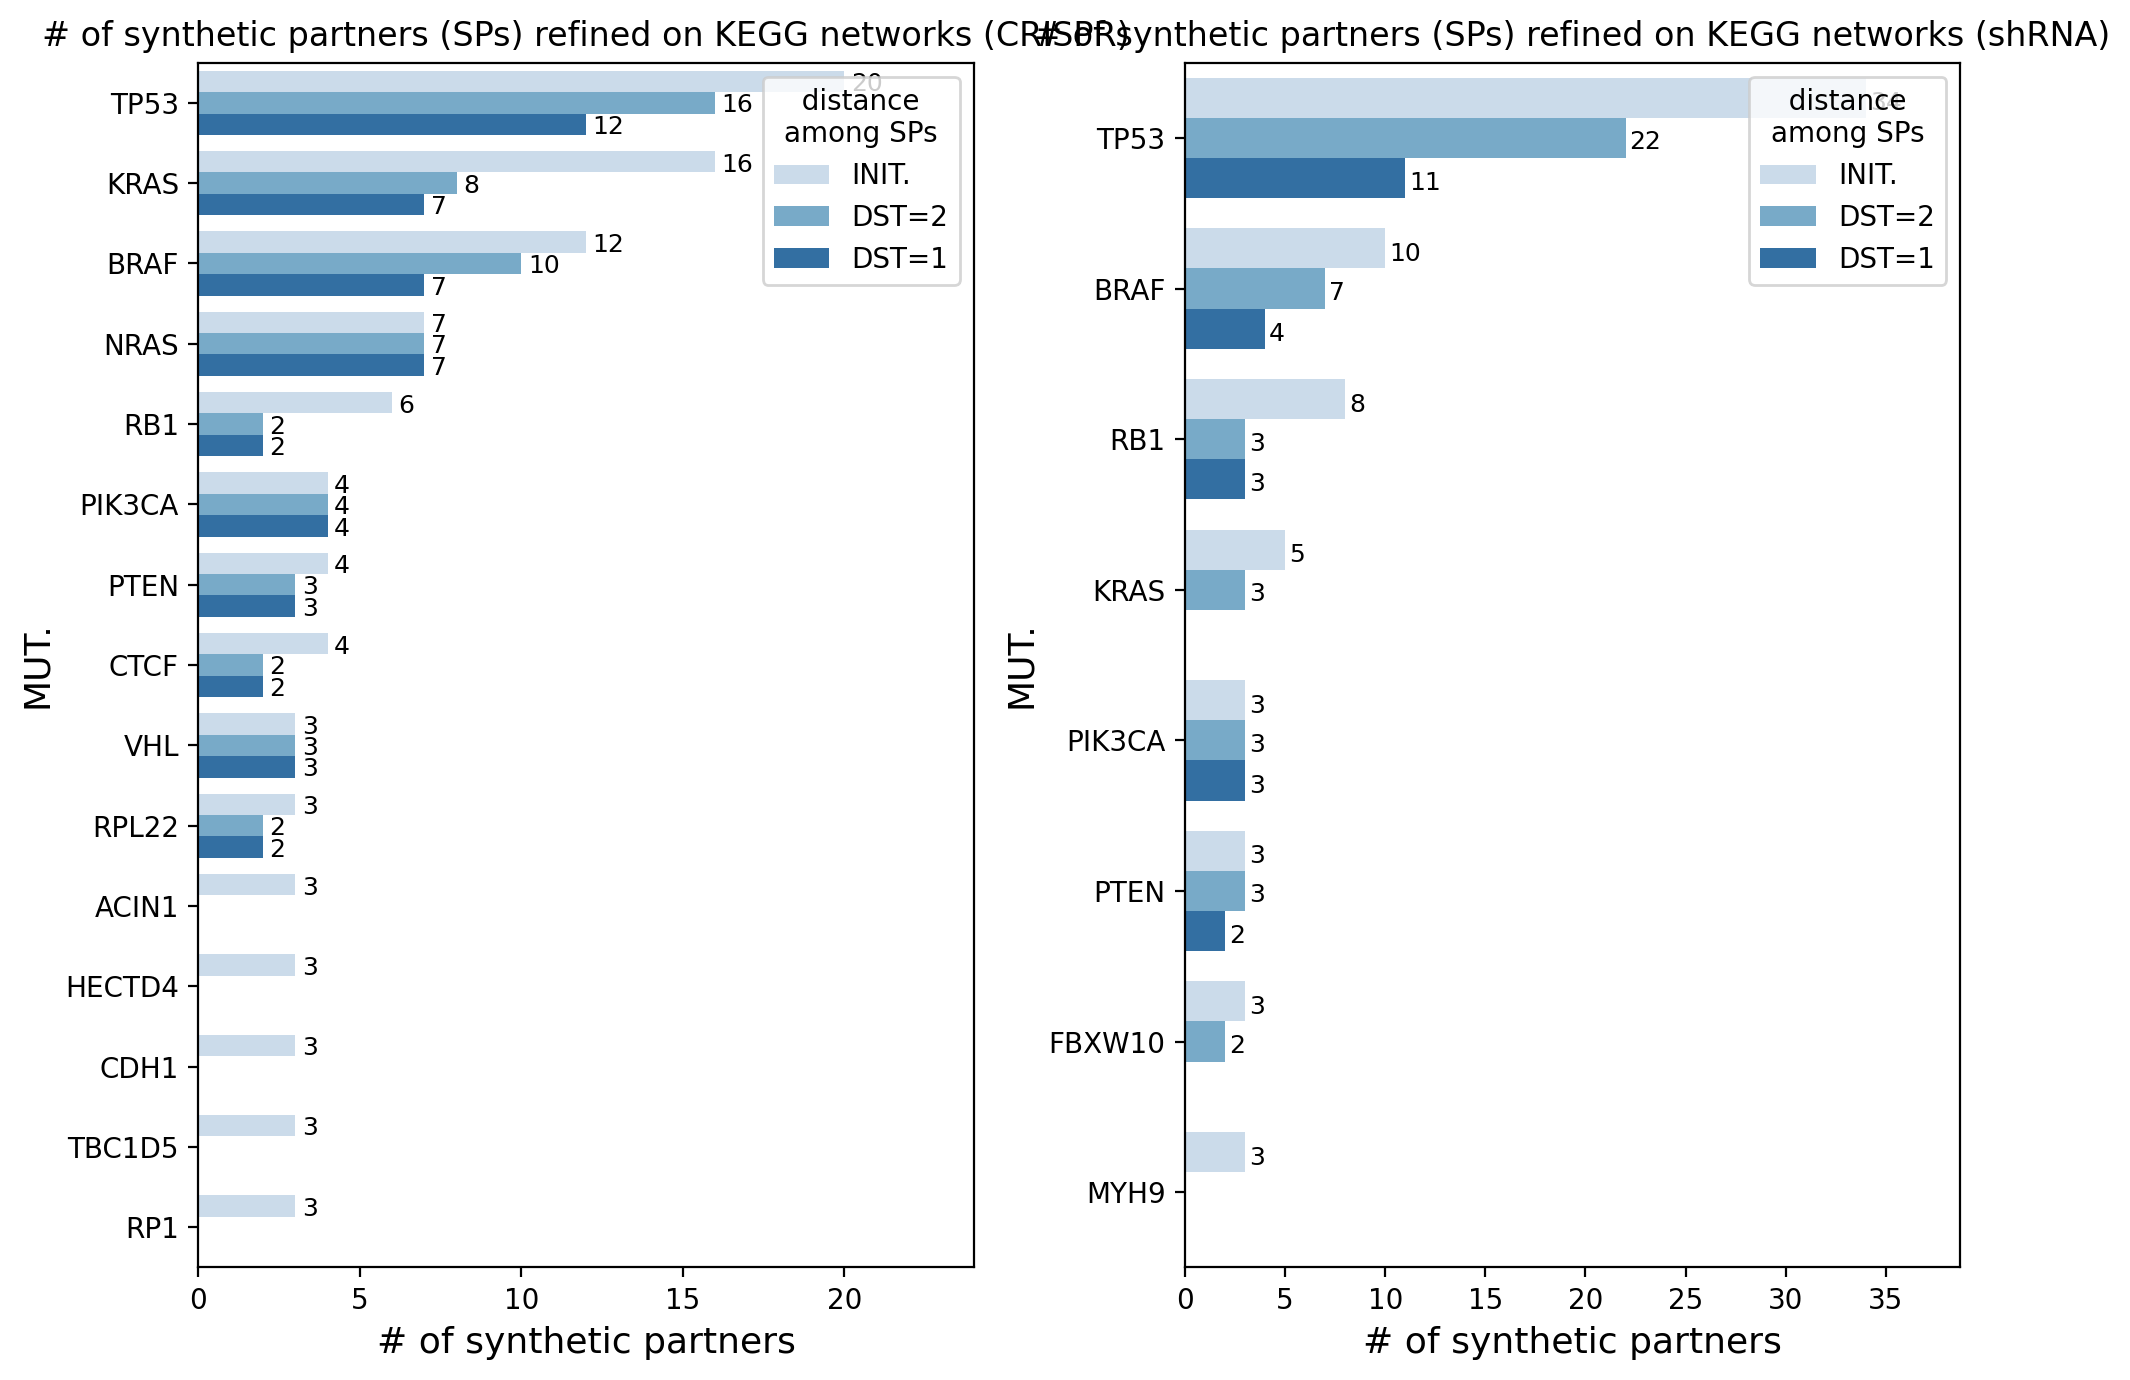

In [8]:
fdr_th=0.2
sig_SL_cnt_th=2

fig=plt.figure(figsize=(10,7), dpi=200)
(ax1,ax2)=fig.subplots(1,2).flatten()


for ax,tp,init,dst2,dst1 in ([ax1,'CRISPR']+crp_list, [ax2,'shRNA']+shr_list):
    all_selected_SL_cnt=pd.concat([init,dst2,dst1], axis=1).reset_index()
    all_selected_SL_cnt.columns=['MUT.','INIT.','DST=2','DST=1']
    all_selected_SL_cnt=all_selected_SL_cnt.sort_values(by=['INIT.','DST=2','DST=1'], ascending=False)
    all_selected_SL_cnt=all_selected_SL_cnt.loc[all_selected_SL_cnt['INIT.']>=3]
    all_selected_SL_cnt_m=all_selected_SL_cnt.melt(id_vars='MUT.', var_name='distance',value_name='# of synthetic partners')
    
    sns.barplot(data=all_selected_SL_cnt_m, y='MUT.', x='# of synthetic partners',
                hue='distance', palette='Blues',order=all_selected_SL_cnt['MUT.'],ax=ax)
    for ii in range(len(all_selected_SL_cnt)):
        (y1,y2,y3)=[int(v1) if v1==v1 else 0 for v1 in list(all_selected_SL_cnt.iloc[ii,1:])]
        if y1!=0:
            _=ax.text(y=ii-0.23,x=y1+0.2,s=y1,ha='left',va='center',fontsize=9)
        if y2!=0:
            _=ax.text(y=ii+0.03,x=y2+0.2,s=y2,ha='left',va='center',fontsize=9)
        if y3!=0:
            _=ax.text(y=ii+0.3,x=y3+0.2,s=y3,ha='left',va='center',fontsize=9)

    _=ax.set_xlim(0,ax.get_xlim()[1]+3)
    _=ax.set_ylabel(ax.get_ylabel(), fontsize=13)
    _=ax.set_xlabel(ax.get_xlabel(), fontsize=13)
    _=ax.legend(bbox_to_anchor=(1, 1), loc='upper right',title='  distance\namong SPs')
    _=ax.set_title("# of synthetic partners (SPs) refined on KEGG networks ({})".format(tp))

fig.tight_layout()

fig.savefig('refined_SP_on_KEGG.jpg',dpi=200)

,MUT.,INIT,RP2,RP1
0,TP53,20,16.0,12.0
1,KRAS,16,8.0,7.0
2,BRAF,12,10.0,7.0
3,NRAS,7,7.0,7.0
4,RB1,6,2.0,2.0
6,PIK3CA,4,4.0,4.0
5,PTEN,4,3.0,3.0
7,CTCF,4,2.0,2.0
9,VHL,3,3.0,3.0
12,RPL22,3,2.0,2.0


<AxesSubplot:xlabel='MUT.', ylabel='# of synthetic partners'>

,MUT.,INIT,RP2,RP1
0,TP53,34,22.0,11.0
1,BRAF,10,7.0,4.0
2,RB1,8,3.0,3.0
3,KRAS,5,3.0,NaN
7,PIK3CA,3,3.0,3.0
6,PTEN,3,3.0,2.0
5,FBXW10,3,2.0,NaN
4,MYH9,3,NaN,NaN


<AxesSubplot:xlabel='MUT.', ylabel='# of synthetic partners'>

Text(0, 0.97, '(a)')

Text(0, 0.5, '(b)')

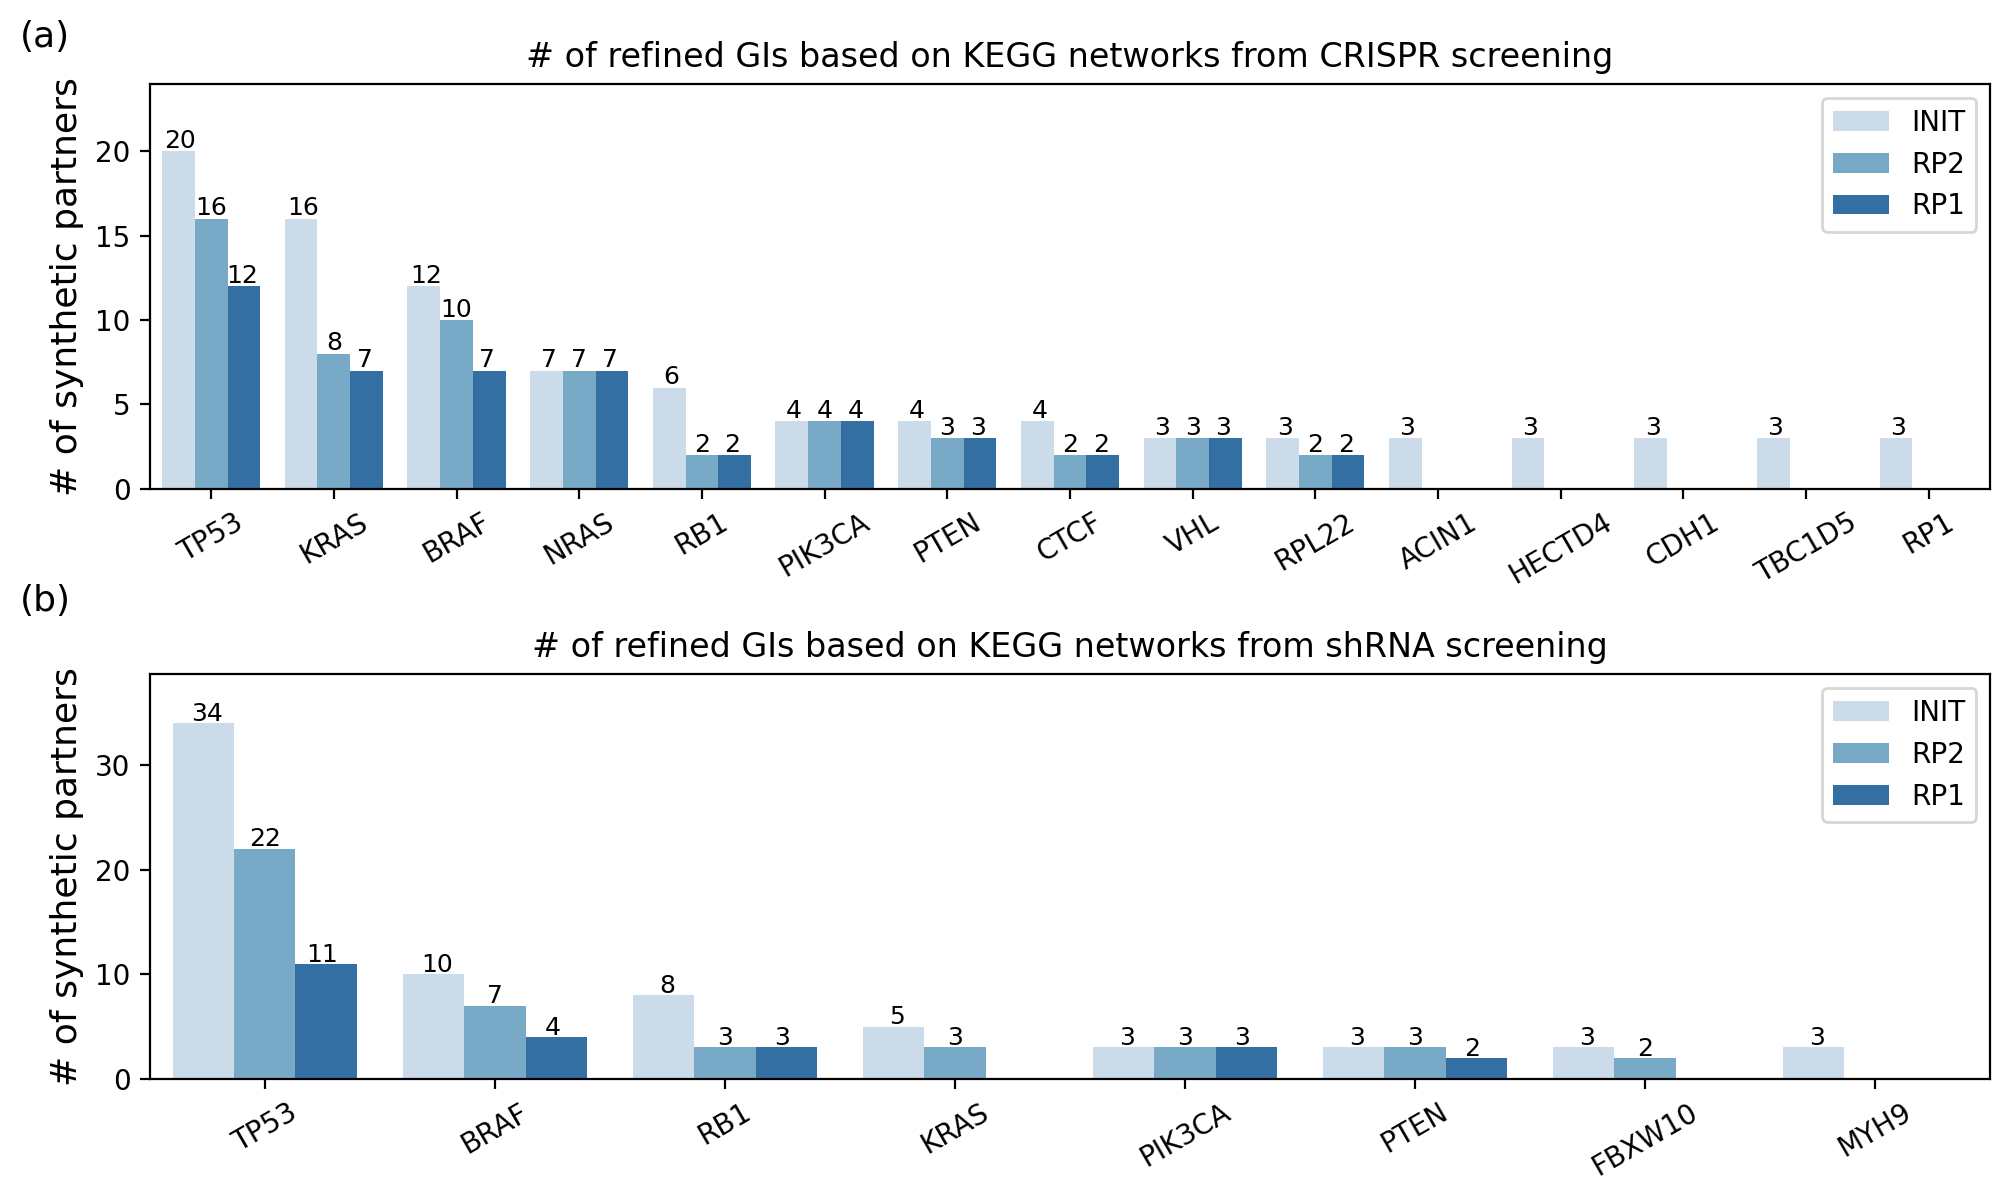

In [9]:
fdr_th=0.2
sig_SL_cnt_th=3

fig=plt.figure(figsize=(10,6), dpi=200)
(ax1,ax2)=fig.subplots(2,1).flatten()


for ax,tp,init,dst2,dst1 in ([ax1,'CRISPR']+crp_list, [ax2,'shRNA']+shr_list):
    all_selected_SL_cnt=pd.concat([init,dst2,dst1], axis=1).reset_index()
    all_selected_SL_cnt.columns=['MUT.','INIT','RP2','RP1']
    all_selected_SL_cnt=all_selected_SL_cnt.sort_values(by=['INIT','RP2','RP1'], ascending=False)
    all_selected_SL_cnt=all_selected_SL_cnt.loc[all_selected_SL_cnt['INIT']>=3]
    all_selected_SL_cnt
    all_selected_SL_cnt_m=all_selected_SL_cnt.melt(id_vars='MUT.', var_name='distance',value_name='# of synthetic partners')
    
    sns.barplot(data=all_selected_SL_cnt_m, x='MUT.', y='# of synthetic partners',
                hue='distance', palette='Blues',order=all_selected_SL_cnt['MUT.'],ax=ax)

    for ii in range(len(all_selected_SL_cnt)):
        (y1,y2,y3)=[int(ii) if ii==ii else 0 for ii in list(all_selected_SL_cnt.iloc[ii,1:])]
        if y1!=0:
            _=ax.text(x=ii-0.25,y=y1+0.2,s=y1,ha='center',fontsize=9)
        if y2!=0:
            _=ax.text(x=ii     ,y=y2+0.2,s=y2,ha='center',fontsize=9)
        if y3!=0:
            _=ax.text(x=ii+0.25,y=y3+0.2,s=y3,ha='center',fontsize=9)
    
    _=ax.set_ylim(0,ax.get_ylim()[1]+3)
    _=ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    _=ax.set_ylabel(ax.get_ylabel(), fontsize=13)
    _=ax.set_xlabel('', fontsize=13)
    _=ax.legend(bbox_to_anchor=(1, 1), loc='upper right')
    _=ax.set_title("# of refined GIs based on KEGG networks from {} screening".format(tp))

fig.tight_layout(h_pad=1.5)

y=0.97
for num in ['(a)','(b)']:
    fig.text(x=0,y=y, s=num, fontsize=13)
    y-=0.47

fig.savefig('refined_SP_on_KEGG.jpg',dpi=200)

# visualization sub network graph per mutated gene

#### Net info
nodes: 1678
edges: 12617
# of the originally selected significant SLs:  1740
# of the SLs in the KEGG net among the selected significant SLs:  525
# of the SLs in the KEGG net equal or more than 3 occurance:  94


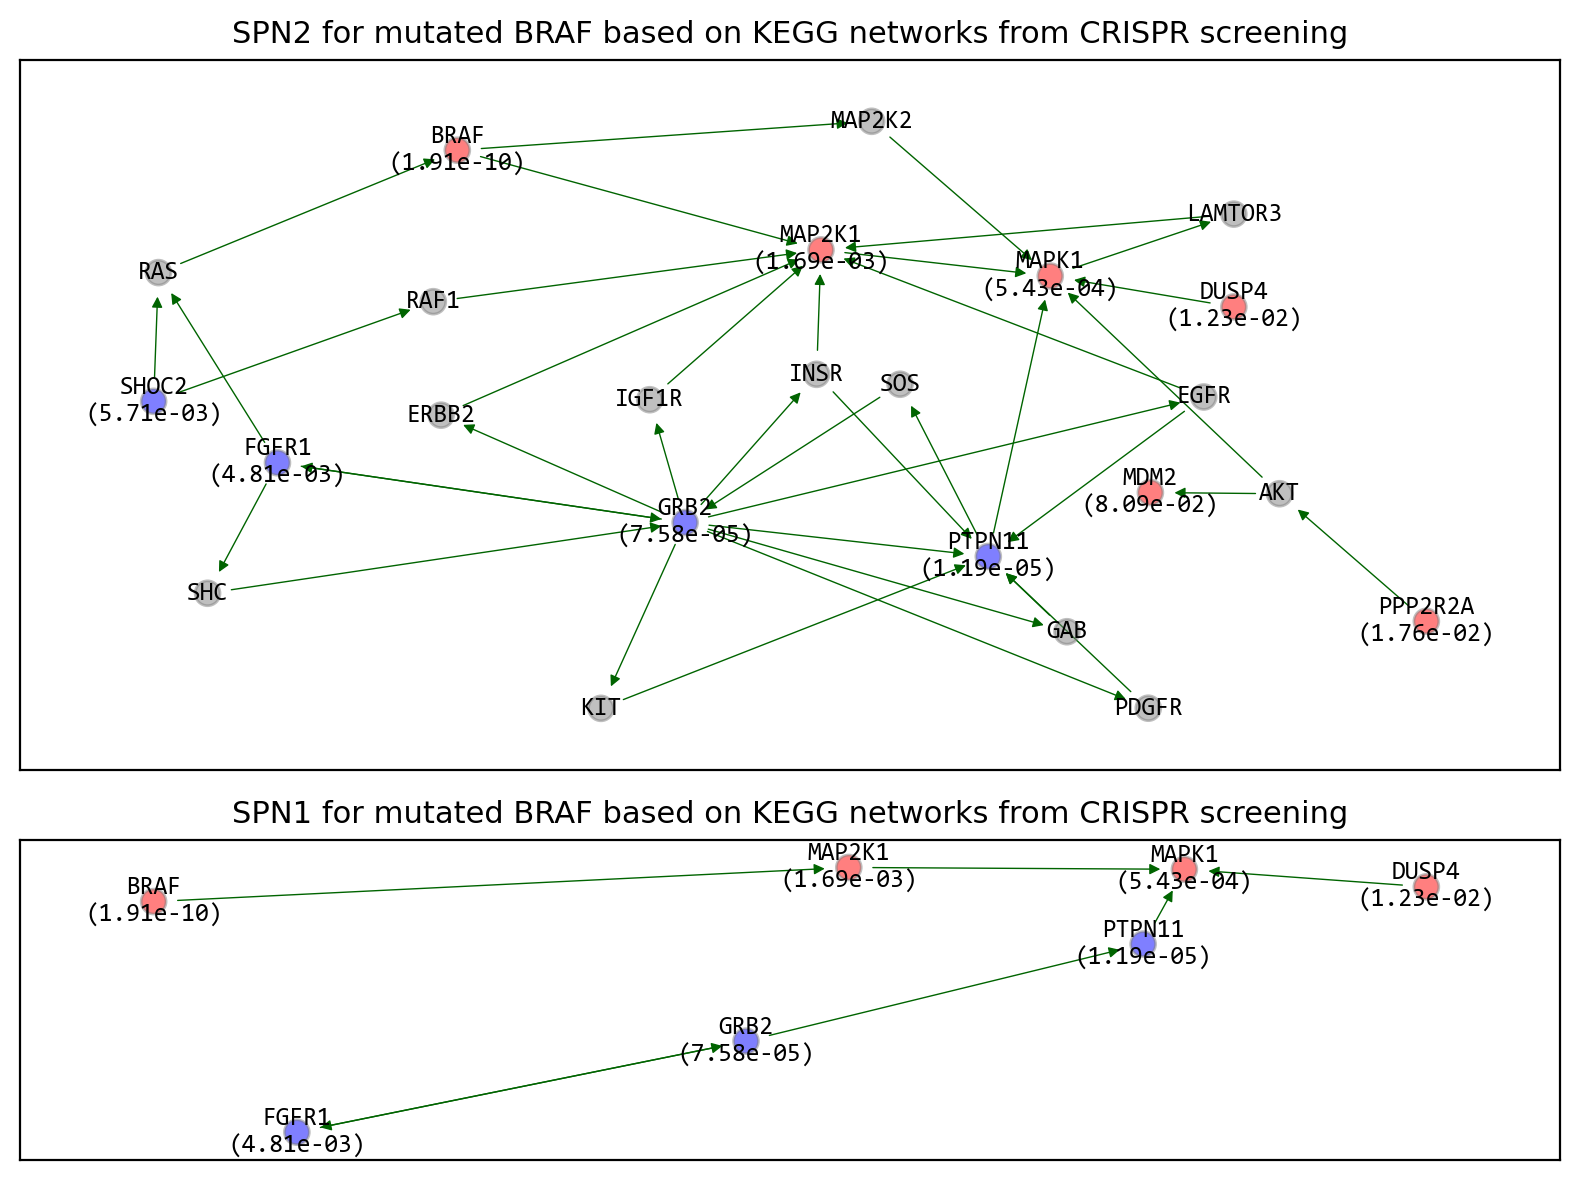

In [10]:
def vis_subnet(SL,tp,mut):
    tp2tp={'crp':'CRISPR','shr':'shRNA'}
    if (tp=='crp') and (mut=='BRAF'):
        fig=plt.figure(figsize=(8,6), dpi=200)
    else:   
        fig=plt.figure(figsize=(8,8), dpi=200)
        
    ax1=plt.subplot2grid(shape=(3,1), loc=(0,0), rowspan=2, fig=fig)   
    ax2=plt.subplot2grid(shape=(3,1), loc=(2,0), fig=fig)   
    sig_SL_cnt_merged, sig_selected_SL, sig_selected_SL_cnt=get_sig_selected_SL(SL, fdr_th, sig_SL_cnt_th, KEGG_all_net)
    
    corrected_SL2, corrected_SL_cnt2=correct_sig_SL_with_KEGG(sig_selected_SL, sig_selected_SL_cnt, SL, tp,
                                                              KEGG_all_net, DST=2, sub_net_vis=True, mut=mut, ax=ax1)
    corrected_SL1, corrected_SL_cnt1=correct_sig_SL_with_KEGG(sig_selected_SL, sig_selected_SL_cnt, SL,tp,
                                                              KEGG_all_net, DST=1, sub_net_vis=True, mut=mut, ax=ax2)
    fig.tight_layout()
    fig.savefig('GIN/GIN_KEGG_{}_{}.jpg'.format(tp2tp[tp], mut))

def KEGG_local_net_visualization(KEGG_local_net, mut_gene,DST,tp, ax):
    tp2tp={'crp':'CRISPR','shr':'shRNA'}
    
    if (DST==2) and (mut_gene=='BRAF') and (tp=='crp'):
        KEGG_local_net.remove_nodes_from(['MRAS', 'RRAS2', 'RRAS', 'HRAS', 'NRAS', 'SOS2',
                                          'PDGFRB','AKT1','AKT2', 'GAB1', 'SHC1', 'SHC2', 'SHC3'])

        mapping={'KRAS':'RAS', 'SOS1':'SOS', 'PDGFRA':'PDGFR', 'AKT3':'AKT', 'GAB2':'GAB', 'SHC4':'SHC'}

        nx.relabel_nodes(KEGG_local_net, mapping, copy=False)
            
    edges, edge_types = zip(*nx.get_edge_attributes(KEGG_local_net,'prop').items())
    nodes, node_weights = zip(*nx.get_node_attributes(KEGG_local_net,'fdr').items())

    
    
    if (mut_gene=='BRAF') and (tp=='crp'):
        graph_pos = nx.kamada_kawai_layout(KEGG_local_net)
        graph_pos['MAPK1']=np.array([0.28,0.5])
        graph_pos['SOS']=np.array([0.1,0.15])
        graph_pos['ERBB2']=np.array([-0.45,0.05])       
        graph_pos['DUSP4']=np.array([0.5,0.4])
        graph_pos['MDM2']=np.array([0.4,-0.2])
        graph_pos['IGF1R']=np.array([-0.2,0.1]) 
        graph_pos['LAMTOR3']=np.array([0.5,0.7])
        graph_pos['GAB']=np.array([0.3,-0.65]) 
    else:
        graph_pos = nx.circular_layout(KEGG_local_net)
        
    node_colors=[]
    node_labels={}
    for nd1,wei in zip(nodes,node_weights):
        if wei!=wei:
            node_colors.append('w')
            node_labels[nd1]=nd1
        elif (wei>0) and (wei<fdr_th):
            node_colors.append('r')
            node_labels[nd1]="{}\n({:.2e})".format(nd1,wei)
        elif (wei<0) and (wei>-fdr_th):
            node_colors.append('b')
            node_labels[nd1]="{}\n({:.2e})".format(nd1,-wei)
        else:
            node_colors.append('gray')
            node_labels[nd1]=nd1
            
    # draw nodes
    _=nx.draw_networkx_nodes(G=KEGG_local_net, pos=graph_pos, nodelist=nodes,
                             node_color=node_colors, alpha=0.5,node_size=80,
                             edgecolors='gray',ax=ax)

    # attach node labels
    _=nx.draw_networkx_labels(G=KEGG_local_net, pos=graph_pos, labels=node_labels ,font_size=9,
                              font_color='black', font_family='Consolas', ax=ax) 

    # draw edges
    _=nx.draw_networkx_edges(G=KEGG_local_net, pos=graph_pos, width=0.5,
                             ax=ax, arrowsize=8, edge_color='darkgreen')
    _=ax.set_title("SPN{} for mutated {} based on KEGG networks from {} screening".format(DST,mut_gene,tp2tp[tp]), fontsize=11)

kgml_list=glob.glob('data_ori/KEGG/selected_pathway_all/hsa*.xml')
KEGG_all_net=construct_kegg_net(kgml_list)
for mut in crp_list[0].index:
    if mut!='BRAF':
        continue
    vis_subnet(crp_SL, 'crp',mut)

# kgml_list=glob.glob('data_ori/KEGG/selected_pathway_all/hsa*.xml')
# KEGG_all_net=construct_kegg_net(kgml_list)
# for mut in shr_list[0].index:
#     vis_subnet(shr_SL, 'shr',mut)
